In [1]:
#ライブラリをインポート
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from ydata_profiling import ProfileReport

In [2]:
#データを読み込む
path ="/kaggle/input/titanic/"
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")
df = pd.concat([train , test])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#Nameから敬称を抽出してカウントする
Titles = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
df["Title"] = Titles 

df["Title"].value_counts()

Title
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: count, dtype: int64

In [4]:
#敬称をまとめる
df["Title"] = df["Title"].replace(["Mlle","Ms"] ,"Miss")
df["Title"] = df["Title"].replace(["Mme","Lady"] ,"Mrs")
df["Title"] = df["Title"].replace(["Dona" , "Countess" , "Dr","Rev" , "Don" , "Major" , "Col" , "Sir" , "Capt" , "Jonkheer"] ,"Rare")
print(df["Title"].value_counts())
print(df['Title'].info())

Title
Mr        757
Miss      264
Mrs       199
Master     61
Rare       28
Name: count, dtype: int64
<class 'pandas.core.series.Series'>
Index: 1309 entries, 0 to 417
Series name: Title
Non-Null Count  Dtype 
--------------  ----- 
1309 non-null   object
dtypes: object(1)
memory usage: 20.5+ KB
None


Fare
8.0500     60
13.0000    59
7.7500     55
26.0000    50
7.8958     49
           ..
7.7417      1
8.1583      1
8.4583      1
7.8000      1
7.7208      1
Name: count, Length: 281, dtype: int64
(array([732., 275.,  64.,  69.,  69.,  16.,  13.,  15.,  14.,   4.,   0.,
         0.,  13.,   5.,   3.,  13.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.]), array([  0.     ,  17.07764,  34.15528,  51.23292,  68.31056,  85.3882 ,
       102.46584, 119.54348, 136.62112, 153.69876, 170.7764 , 187.85404,
       204.93168, 222.00932, 239.08696, 256.1646 , 273.24224, 290.31988,
       307.39752, 324.47516, 341.5528 , 358.63044, 375.70808, 392.78572,
       409.86336, 426.941  , 444.01864, 461.09628, 478.17392, 495.25156,
       512.3292 ]), <BarContainer object of 30 artists>)


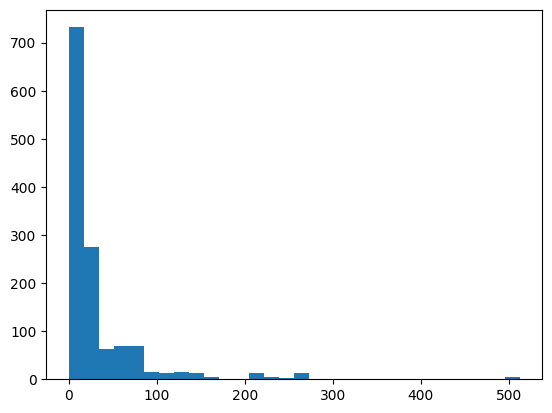

In [5]:
#欠損値を埋める。Fareをとりあえず中央値で埋める。
df["Fare"] = df["Fare"].fillna(df["Fare"].median())
print(df['Fare'].value_counts())
print(plt.hist(data=df , x="Fare", bins=30))

In [6]:
#AgeはTitleごとの中央値で埋める
df["Age"] = df["Age"].fillna(df.groupby("Title")["Age"].transform("median"))
df.isnull().sum()
print(df["Age"].value_counts())

Age
29.0    206
22.0     94
24.0     47
21.0     41
30.0     40
       ... 
23.5      1
20.5      1
55.5      1
66.0      1
38.5      1
Name: count, Length: 99, dtype: int64


In [7]:
#特徴量エンジニアリング
#EmbarkedとSexとTitleをワンホットエンコーディングする。
emb = pd.get_dummies(df["Embarked"],prefix="Emb")
sx = pd.get_dummies(df["Sex"],prefix="Sex")
ttl = pd.get_dummies(df["Title"],prefix="Title")

#新しい特徴量として、Famsize,Isalone,IsFareZeroを追加する。
df["Famsize"] = df["SibSp"] + df["Parch"] + 1
df["Isalone"] = df["Famsize"]==1
df["IsFareZero"] = df["Fare"]==0

#追加した特徴量をデータフレームへ統合する。不要なカラムは削除する。
df2 = pd.concat([df, emb, sx, ttl],axis=1)
df3 = df2.drop(columns=["Sex_male", "Sex", "Embarked", "Title", "Cabin", "Ticket", "Name"])

df3.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Famsize,Isalone,IsFareZero,Emb_C,Emb_Q,Emb_S,Sex_female,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,1,0.0,3,22.0,1,0,7.2500,2,False,False,False,False,True,False,False,False,True,False,False
1,2,1.0,1,38.0,1,0,71.2833,2,False,False,True,False,False,True,False,False,False,True,False
2,3,1.0,3,26.0,0,0,7.9250,1,True,False,False,False,True,True,False,True,False,False,False
3,4,1.0,1,35.0,1,0,53.1000,2,False,False,False,False,True,True,False,False,False,True,False
4,5,0.0,3,35.0,0,0,8.0500,1,True,False,False,False,True,False,False,False,True,False,False


In [8]:
#機械学習モデルに投入するデータを作成する。
train_df = df3[~df3["Survived"].isnull()]
test_df = df3[df3["Survived"].isnull()]

train_x = train_df.drop(columns=["Survived"])
train_y = train_df["Survived"]
train_y.info()

<class 'pandas.core.series.Series'>
Index: 891 entries, 0 to 890
Series name: Survived
Non-Null Count  Dtype  
--------------  -----  
891 non-null    float64
dtypes: float64(1)
memory usage: 13.9 KB


# ↓ランダムフォレスト

In [9]:
# ランダムフォレストモデル（分類器）の定義
# n_estimators: 使用する決定木の数（一般的に多いほど性能が向上するが、計算時間が増える）
# max_depth: 決定木の深さの最大値（過学習を防ぐために設定することが多い）
rf_model = RandomForestClassifier(
    n_estimators=200,      # 適切な木の本数
    max_depth=7,           # 深さを制限（過学習対策）
    min_samples_split=10,  # 分岐の条件を厳しくする
    min_samples_leaf=5,    # 葉のサイズを大きくする
    random_state=42,
    n_jobs=-1
)

# **↓LithtGBM**

In [10]:
#機械学習モデルを呼び出し、学習を行う。
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.03,    # 低めに設定
    n_estimators=150,      # 試行回数
    num_leaves=8,          # 浅い木に制限（過学習対策）
    max_depth=5,           # 深さの制限
    random_state=42,
)
print("LightGBMのハイパーパラメータを設定しました。")

LightGBMのハイパーパラメータを設定しました。


In [11]:
#↓どちらのモデルで学習するか、選んでネ！

#rf_model.fit(train_x , train_y)
lgb_model.fit(train_x , train_y)

print("学習が完了しました")

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 502
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
学習が完了しました


In [12]:
#交差検証を開始する。5分割がよさそう。
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# cross_val_scoreで精度（accuracy）を計算
# scoring='accuracy' はタイタニックの評価指標
accuracy_scores = cross_val_score(
    estimator=lgb_model, 
    X=train_x, 
    y=train_y, 
    cv=skf, 
    scoring='accuracy',
    n_jobs=-1 # 全てのコアを使って並列処理（高速化）
)

# 結果の表示
print(f"各分割での精度スコア ({N_SPLITS}-Fold): {accuracy_scores}")
print(f"----------------------------------------")
print(f"平均精度 (Mean Accuracy): {accuracy_scores.mean():.4f}")
print(f"スコアの標準偏差 (Std Dev): {accuracy_scores.std():.4f}")

各分割での精度スコア (5-Fold): [0.84357542 0.83707865 0.80898876 0.82022472 0.81460674]
----------------------------------------
平均精度 (Mean Accuracy): 0.8249
スコアの標準偏差 (Std Dev): 0.0133


In [13]:
test_df.tail()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Famsize,Isalone,IsFareZero,Emb_C,Emb_Q,Emb_S,Sex_female,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
413,1305,NaN,3,29.0,0,0,8.0500,1,True,False,False,False,True,False,False,False,True,False,False
414,1306,NaN,1,39.0,0,0,108.9000,1,True,False,True,False,False,True,False,False,False,False,True
415,1307,NaN,3,38.5,0,0,7.2500,1,True,False,False,False,True,False,False,False,True,False,False
416,1308,NaN,3,29.0,0,0,8.0500,1,True,False,False,False,True,False,False,False,True,False,False
417,1309,NaN,3,4.0,1,1,22.3583,3,False,False,True,False,False,False,True,False,False,False,False


In [14]:
#予測用データの作成をする
test_x = test_df.drop(columns=["Survived"])
test_y = test_df["Survived"]
print("予測用データの作成が完了しました")

予測用データの作成が完了しました


In [15]:
#学習したパラメータをテストデータへ適用して予測する。
test_y = lgb_model.predict(test_x)

#提出用のデータを作る。
submission_df = pd.DataFrame({
    "PassengerId" : test_df["PassengerId"],
    "Survived" : test_y.astype(int)
})

#csvで書き出す
submission_df.to_csv("first_submission12_IsFareZero.csv" , index=False)
print("書き出しが完了しました")

書き出しが完了しました


In [16]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 9.8 KB


In [17]:
# プロファイルレポートの生成
profile = ProfileReport(train_df, title='My Data Profiling Report')
# HTMLファイルとして保存
profile.to_file("my_report.html")

/usr/local/lib/python3.11/dist-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 19/19 [00:00<00:00, 130002.90it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
farezero =train_df[train_df["Fare"]==0]
farezero

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Famsize,Isalone,IsFareZero,Emb_C,Emb_Q,Emb_S,Sex_female,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
179,180,0.0,3,36.0,0,0,0.0,1,True,True,False,False,True,False,False,False,True,False,False
263,264,0.0,1,40.0,0,0,0.0,1,True,True,False,False,True,False,False,False,True,False,False
271,272,1.0,3,25.0,0,0,0.0,1,True,True,False,False,True,False,False,False,True,False,False
277,278,0.0,2,29.0,0,0,0.0,1,True,True,False,False,True,False,False,False,True,False,False
302,303,0.0,3,19.0,0,0,0.0,1,True,True,False,False,True,False,False,False,True,False,False
413,414,0.0,2,29.0,0,0,0.0,1,True,True,False,False,True,False,False,False,True,False,False
466,467,0.0,2,29.0,0,0,0.0,1,True,True,False,False,True,False,False,False,True,False,False
481,482,0.0,2,29.0,0,0,0.0,1,True,True,False,False,True,False,False,False,True,False,False
597,598,0.0,3,49.0,0,0,0.0,1,True,True,False,False,True,False,False,False,True,False,False
633,634,0.0,1,29.0,0,0,0.0,1,True,True,False,False,True,False,False,False,True,False,False


次：
①ランダムフォレストに変えてみる→LithtGBMよりスコアが伸びなそう。
ハイパーパラメータチューニングを頑張ってみる。→結構よい感じになってきた。
②Fare=0の乗客がかなりいる。調べてみると、ほぼ生き残っていないので、新しい特徴量（IsFareZero）を作ってみる。→あとは提出するのみ